In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
#IMPORTS
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [46]:
loc = 'nw2'
turbine = 'c02'
mode = 'SS2'

In [47]:
# Initialize the folders
package_folder = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
data_folder = os.path.join(package_folder, 'data')
data_folder

'c:\\Users\\Max\\Documents\\OWI_LAB\\Code\\DCE_EOVnorm\\dce_eov_normalisation\\data'

In [48]:
# GET THE DATA
# load the training data full
from src.data.make_dataset import create_input_target_dataset
inputs_training_full, ss2_training_full = create_input_target_dataset(data_folder, loc, turbine, mode)

#load the predictions of the training data
predictions_df_training = pd.read_parquet(os.path.join(data_folder, 'processed', loc, turbine+'_'+mode+'_mode_prediction_large_training.parquet'))
smart_tracked_modes_training = pd.read_parquet(os.path.join(data_folder, 'processed', loc, turbine+'_'+mode+'_smart_tracked_modes_large_training.parquet'))
case_IDS = pd.read_csv(os.path.join(data_folder, 'interim', loc,'labeled', loc+turbine+'_case.csv'))

# load the training data selected
selected_data_large = pd.read_csv(os.path.join(data_folder, 'processed','nw2', turbine+'_ss2_selected_data_large.csv'))
# Remove the selecyted data with duplicated timestamps and keep the one with the biggest size
selected_data_sorted = selected_data_large.sort_values(by='size', ascending=False)
selected_data_unique = selected_data_sorted.drop_duplicates(subset='timestamp', keep='first')
selected_data_unique = selected_data_unique.sort_values(by='timestamp')

# load the test data
test_data_path = '_'.join([loc, turbine, mode, 'test_data.parquet'])
test_turbine_data = pd.read_parquet(os.path.join(data_folder, 'raw', loc, test_data_path))


# load the data and the predictions of the test data
input_data_test = pd.read_parquet(os.path.join(data_folder, 'processed', loc,'test_2023_06_12_predictions', '_'.join([loc, turbine, mode]) +'input.parquet'))
ss2_test = pd.read_parquet(os.path.join(data_folder, 'processed', loc,'test_2023_06_12_predictions', '_'.join([loc, turbine, mode]) +'ss2.parquet'))
predictions_df_test = pd.read_parquet(os.path.join(data_folder, 'processed', loc,'test_2023_06_12_predictions', '_'.join([loc, turbine, mode]) +'predictions.parquet'))
virtual_ensemble_preds_df_test = pd.read_parquet(os.path.join(data_folder, 'processed', loc,'test_2023_06_12_predictions', '_'.join([loc, turbine, mode]) +'virtual_ensemble_predictions.parquet'))
smart_tracked_modes_test = pd.read_parquet(os.path.join(data_folder, 'processed', loc,'test_2023_06_12_predictions', '_'.join([loc, turbine, mode]) +'smart_tracked_modes.parquet'))

dropped mvbc columns:  {'mvbc_WandelaarMeasuringpile_Relative_humidity', 'mvbc_WandelaarBuoy_Sea_water_temperature'}


In [49]:
case_IDS.set_index('timestamp', inplace=True)
case_IDS.index = pd.to_datetime(case_IDS.index) 

In [50]:
case_IDS.loc[predictions_df_training.index]
#replace caseID unique strings with integers
cases = {}
for i, case in enumerate(case_IDS['caseID'].unique()):
    case_IDS['caseID'].replace(case, i, inplace=True)
    cases[i] = case


In [51]:
cases

{0: nan,
 1: 'Rated RPM: Turbine rotating at 10.4rpm or 10.445rpm',
 2: 'rpm<Max: Turbine speeding up to rated RPM',
 3: 'rpm<6.6: Turbine rotating up to 6.6RPM',
 4: 'cutin (pitch 60): Turbine speeding up to operational speeds',
 5: 'pitch:78: Turbine pitched at 78deg.',
 6: 'rpm6.6: Turbine rotating at 6.6 RPM',
 7: 'cutin: Turbine speeding up to operational speeds',
 8: 'idling: Generic idling (no constraint on pitch)',
 9: 'parked: Turbine parked, pitched at >87, rotating at less than 0.4RPM',
 10: 'High wind: Turbine reducing output power at extreme wind speeds'}

In [64]:
ss2_df = pd.DataFrame(ss2_training_full, index=inputs_training_full.index, columns=['ss2'])
ss2_df['caseID'] = case_IDS.loc[ss2_df.index]['caseID']

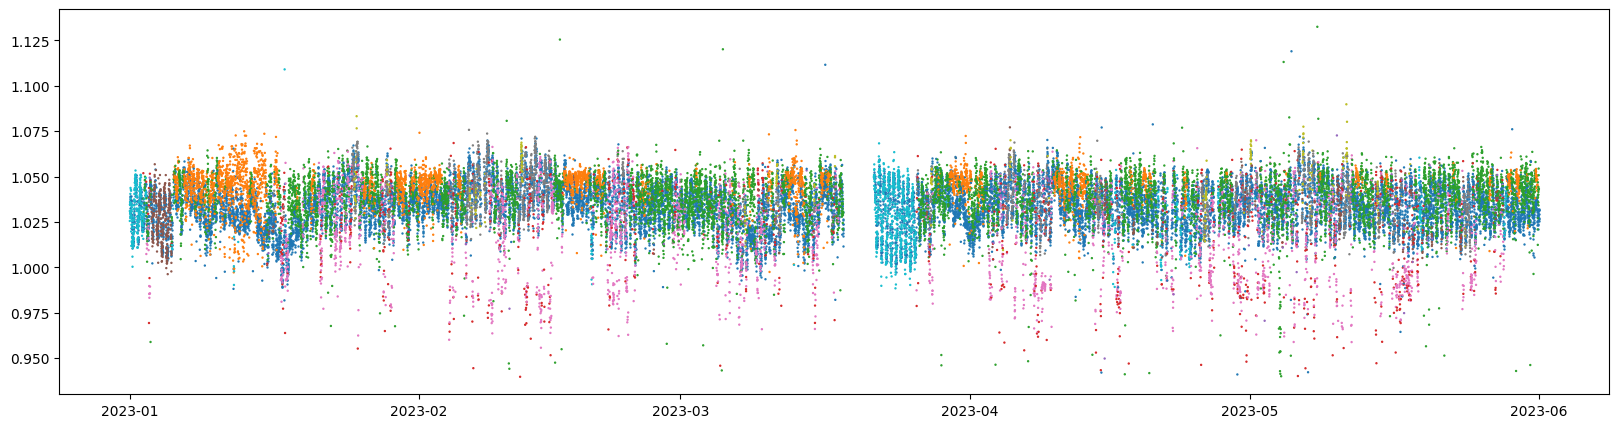

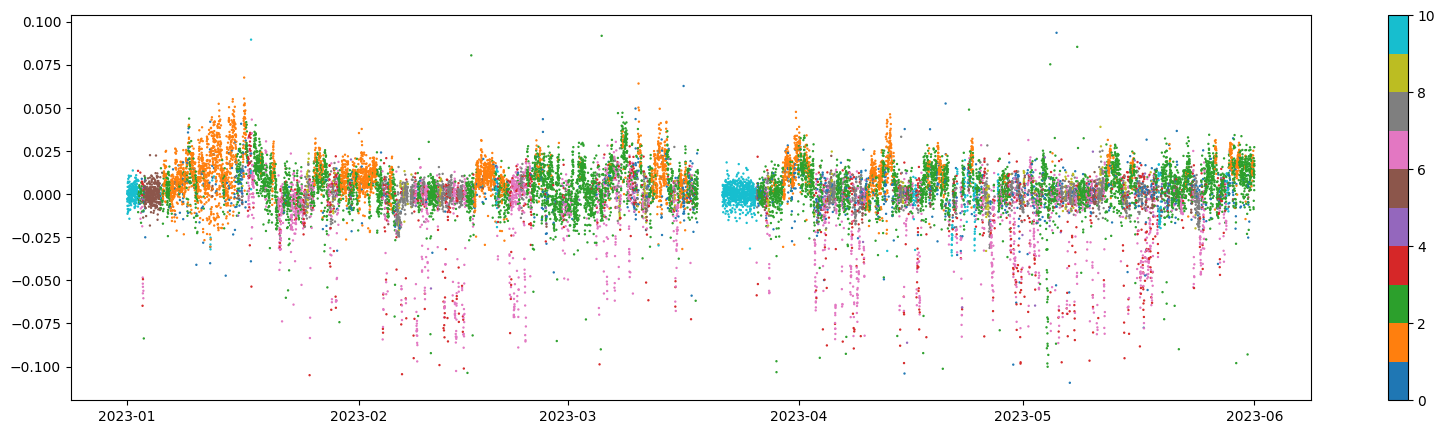

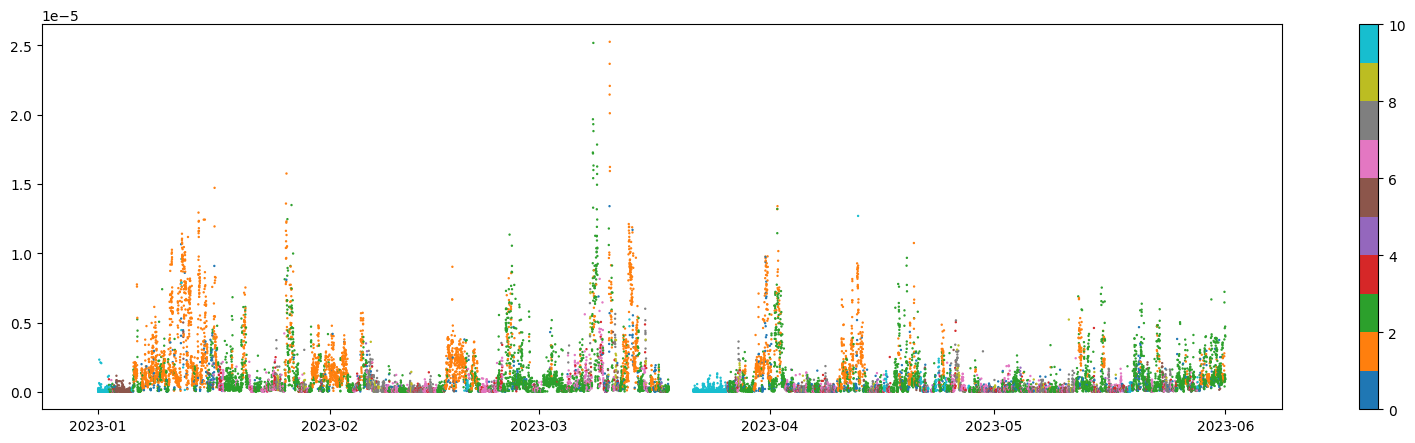

In [76]:
plt.figure(figsize=(20,5))
plt.scatter(predictions_df_training.index, predictions_df_training['prediction'], s=0.5)
plt.scatter(ss2_training_full.index, ss2_training_full,c=ss2_df['caseID'], s=0.5, cmap='tab10')
plt.show()
plt.close()
plt.figure(figsize=(20,5))
plt.scatter(predictions_df_training.index, predictions_df_training['residual'], c=case_IDS.loc[predictions_df_training.index]['caseID'],cmap='tab10', s=0.5)
cbar = plt.colorbar()
plt.show()
plt.close()
plt.figure(figsize=(20,5))
plt.scatter(predictions_df_training.index, predictions_df_training['knowledge_uncertainty'], c=case_IDS.loc[predictions_df_training.index]['caseID'],cmap='tab10', s=0.5)
cbar = plt.colorbar()
plt.show()
plt.close()

In [71]:
smart_tracked_modes_training

,frequency,distance_to_prediction
timestamp,,
2023-01-01 03:00:00+00:00,1.035454,0.000588
2023-01-01 03:10:00+00:00,1.030419,0.001538
2023-01-01 03:20:00+00:00,1.042198,0.008848
2023-01-01 03:30:00+00:00,1.019736,0.008695
2023-01-01 03:40:00+00:00,1.030911,0.000064
...,...,...
2023-05-28 10:30:00+00:00,1.033024,0.002199
2023-05-28 10:40:00+00:00,1.035364,0.003938
2023-05-28 10:50:00+00:00,1.044243,0.011010


Text(0, 0.5, 'residual')

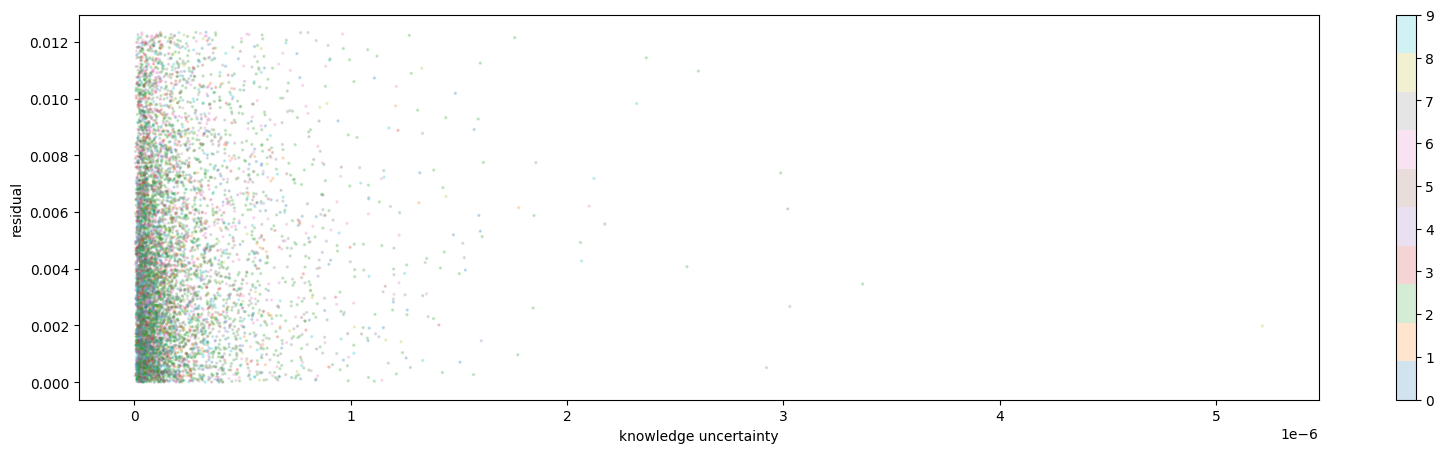

In [73]:
smart_tracked_modes_training
plt.figure(figsize=(20,5))
plt.scatter(predictions_df_training['knowledge_uncertainty'].loc[smart_tracked_modes_training.index], 
            np.abs(predictions_df_training['residual'].loc[smart_tracked_modes_training.index]),c=case_IDS.loc[smart_tracked_modes_training.index]['caseID'],
            label='training data', s=2, alpha = 0.2, cmap='tab10')
cbar = plt.colorbar()
cbar.set_alpha(1)
plt.xlabel('knowledge uncertainty')
plt.ylabel('residual')

Text(0, 0.5, 'residual')

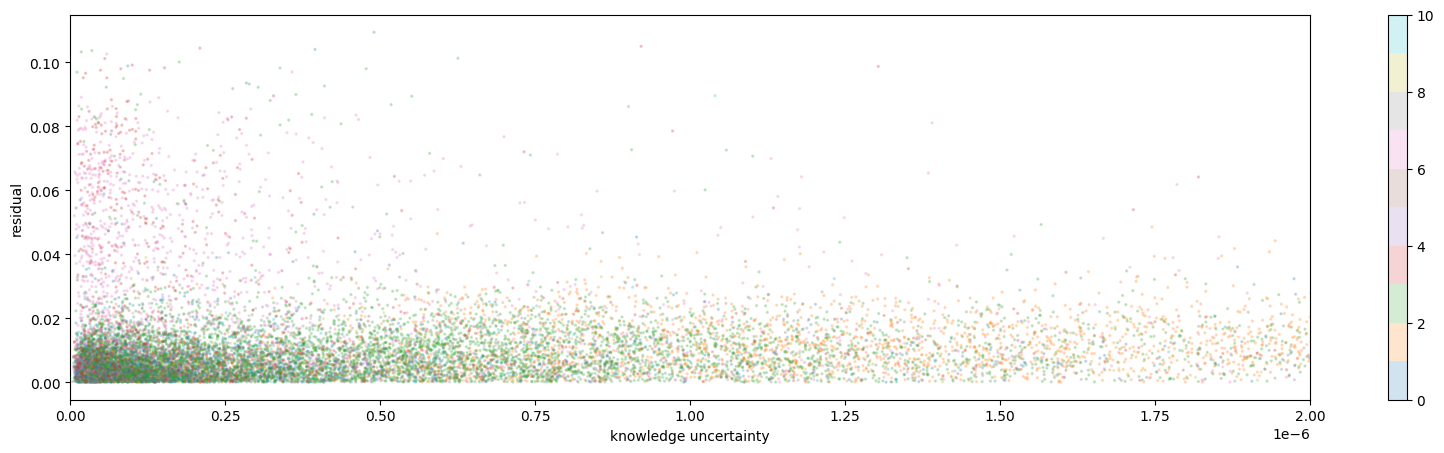

In [52]:
plt.figure(figsize=(20,5))
plt.scatter(predictions_df_training['knowledge_uncertainty'], np.abs(predictions_df_training['residual']),c=case_IDS.loc[predictions_df_training.index]['caseID'], label='training data', s=2, alpha = 0.2, cmap='tab10')
cbar = plt.colorbar()
cbar.set_alpha(1)
plt.xlabel('knowledge uncertainty')
plt.xlim(0,0.2*1e-5)
plt.ylabel('residual')

In [55]:
predictions_df_training

,prediction,spread,virtual_ensemble_mean,knowledge_uncertainty,data_uncertainty,residual
timestamp,,,,,,
2023-01-01 00:00:00+00:00,1.028394,0.000003,1.027630,1.800891e-07,0.000002,-0.002835
2023-01-01 00:10:00+00:00,1.030524,0.000002,1.029510,2.598539e-07,0.000004,0.000586
2023-01-01 00:20:00+00:00,1.032770,0.000018,1.032881,3.932435e-08,0.000017,0.001781
2023-01-01 00:30:00+00:00,1.035109,0.000013,1.035320,2.634037e-08,0.000015,-0.004330
2023-01-01 00:40:00+00:00,1.035994,0.000006,1.036264,3.349582e-08,0.000007,0.000041
...,...,...,...,...,...,...
2023-05-31 23:20:00+00:00,1.027236,0.000030,1.029699,4.070574e-06,0.000027,0.027193
2023-05-31 23:30:00+00:00,1.025284,0.000018,1.027965,4.707075e-06,0.000020,0.017518
2023-05-31 23:40:00+00:00,1.031509,0.000017,1.032690,9.444945e-07,0.000021,0.019219


9


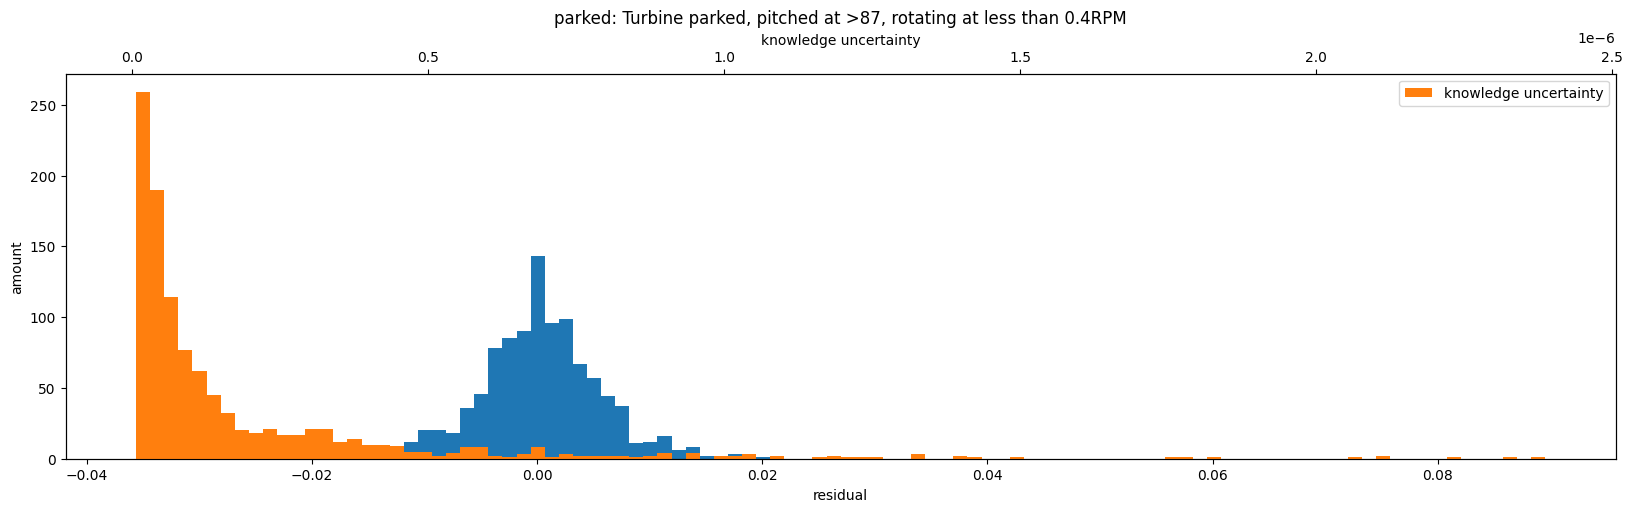

3


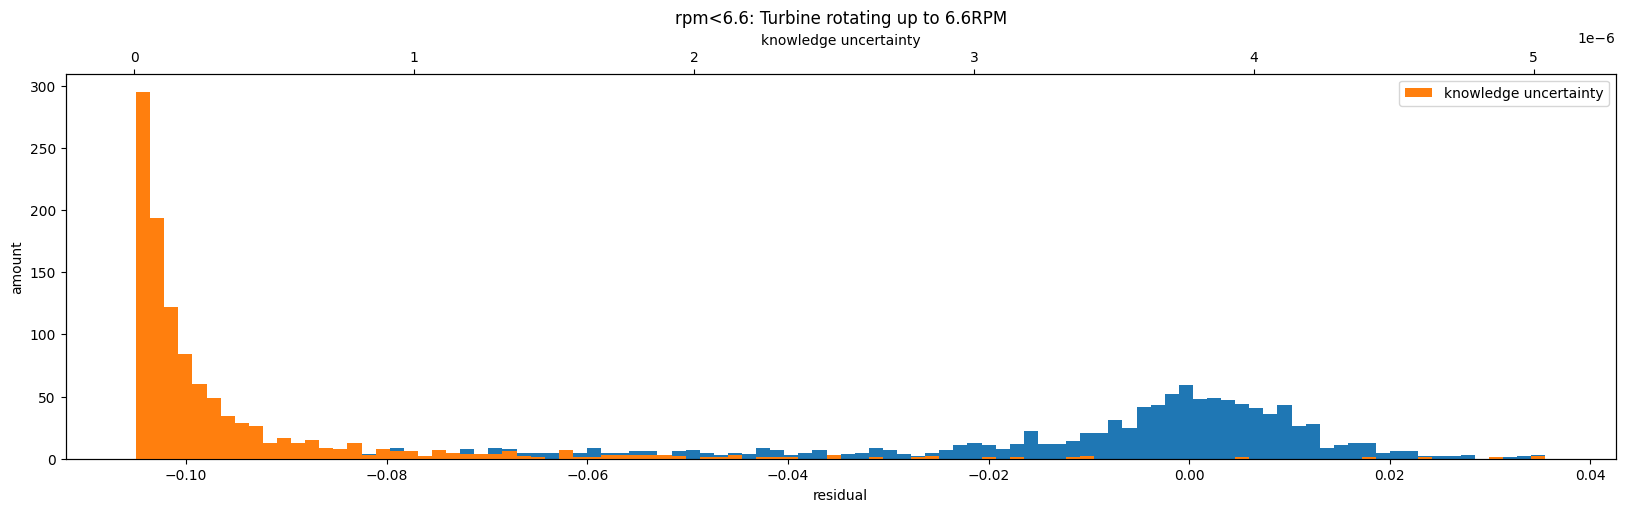

2


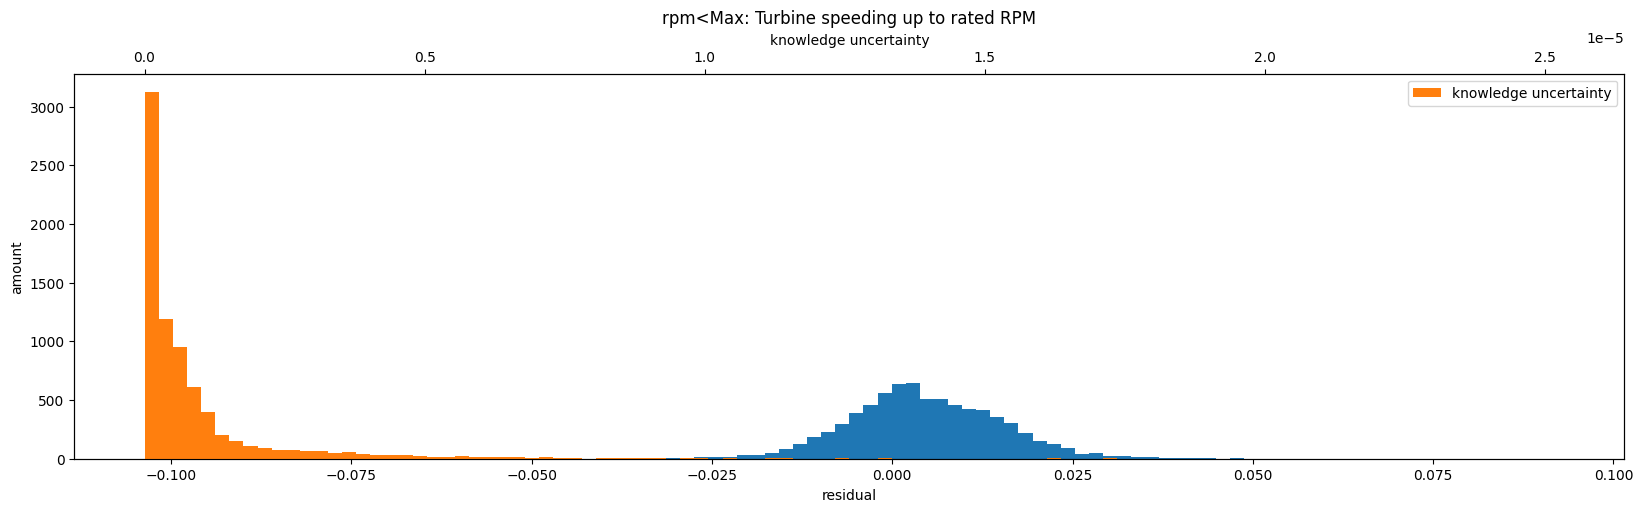

0


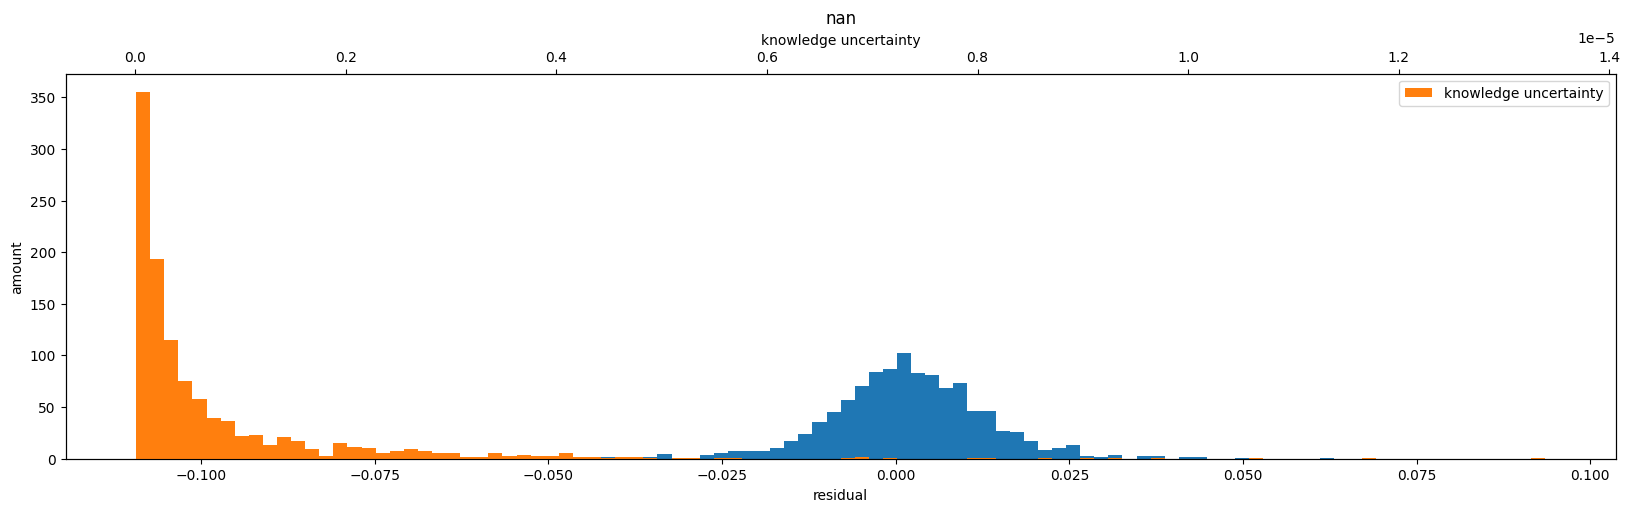

6


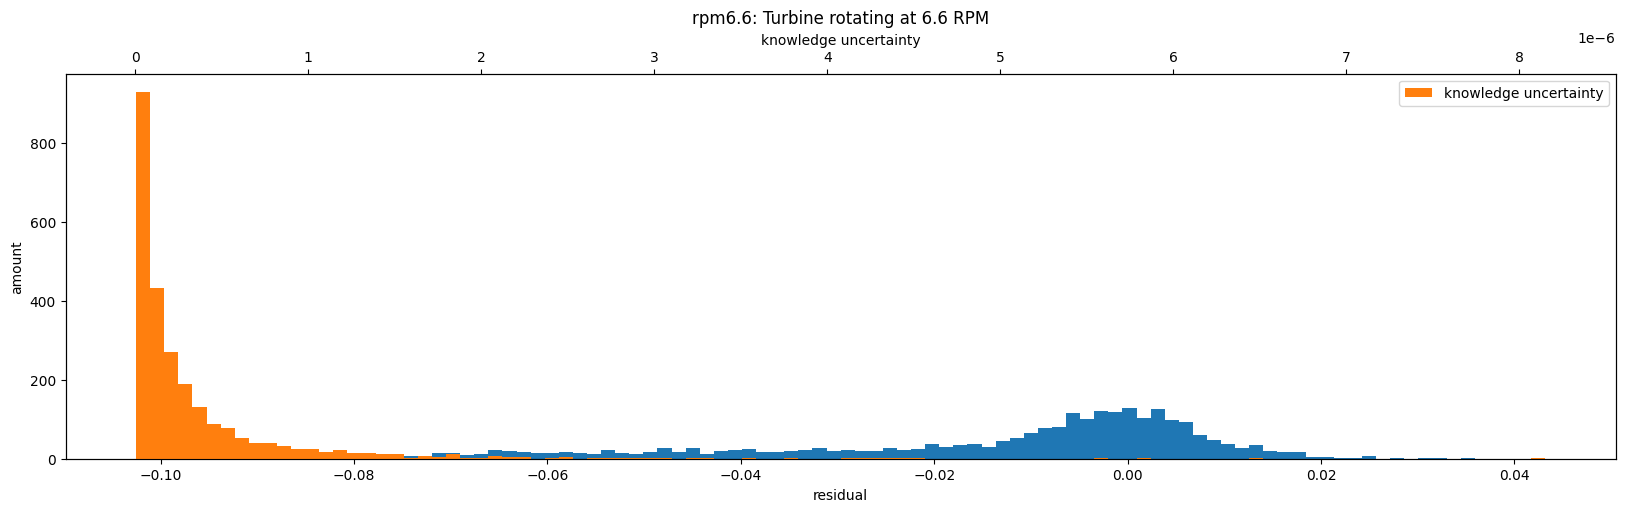

7


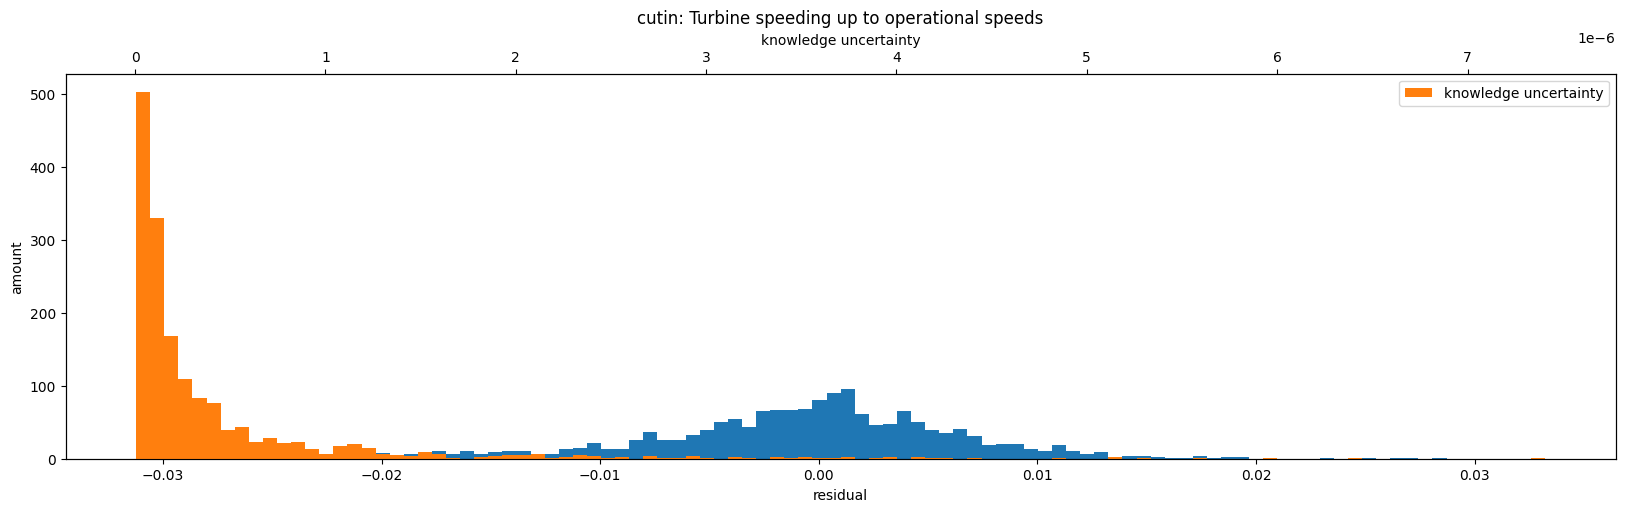

5


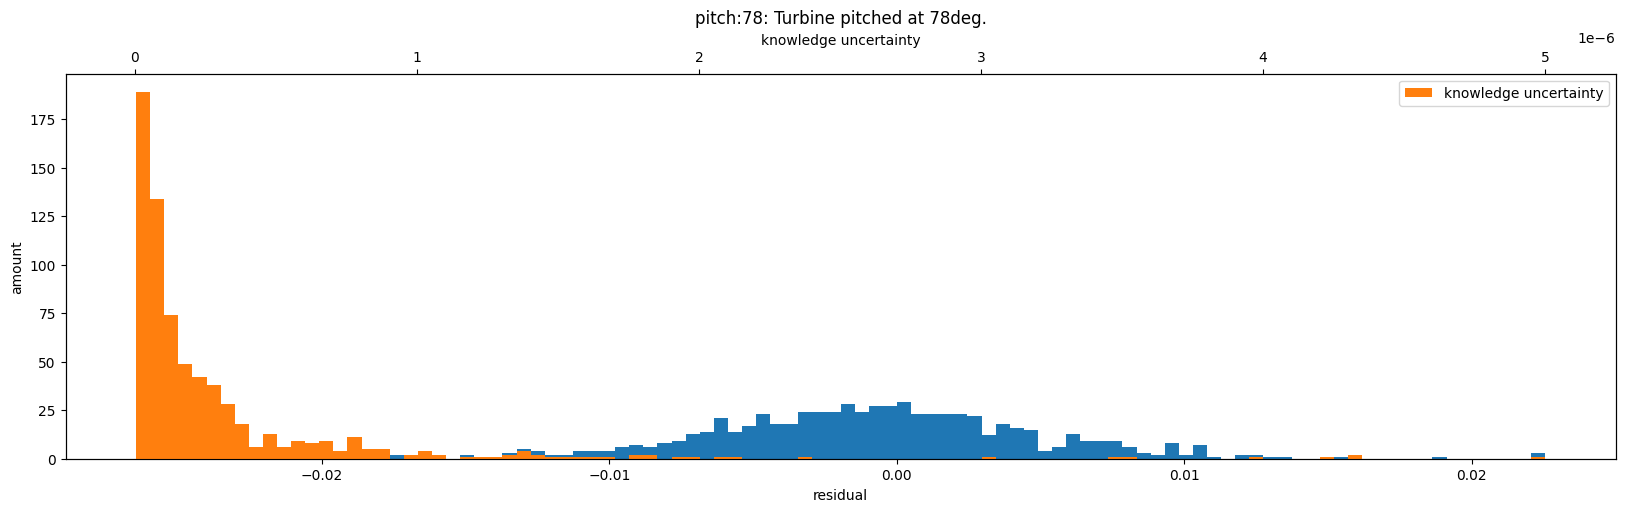

4


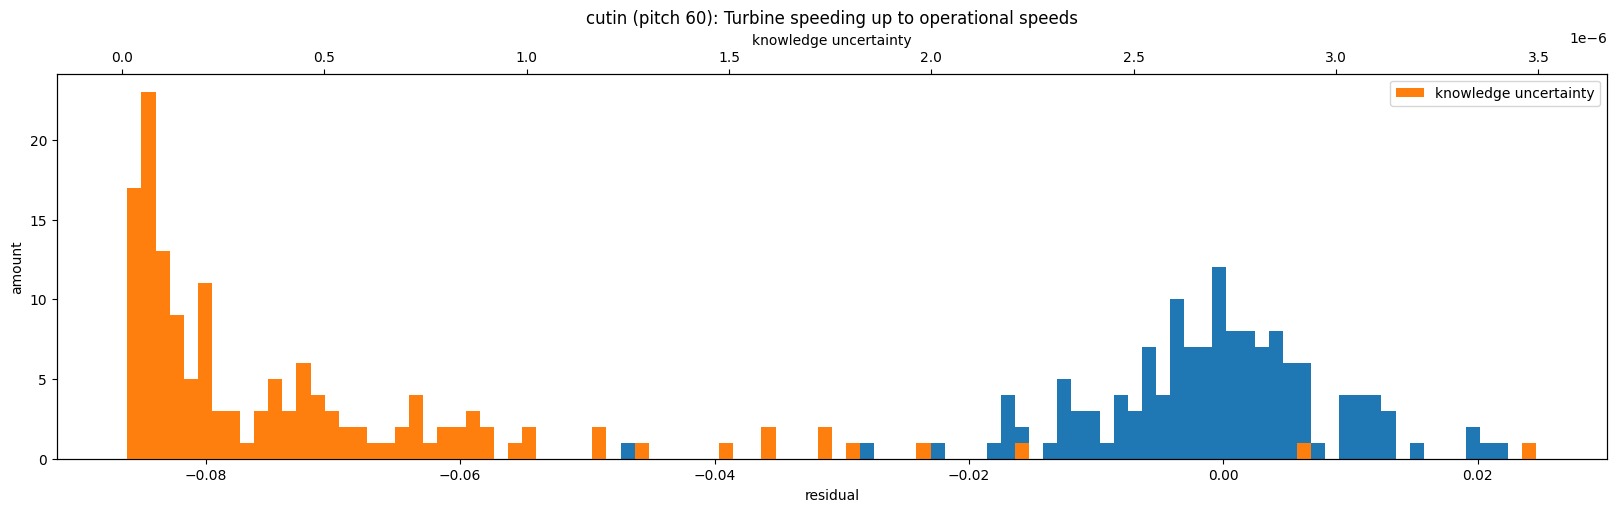

1


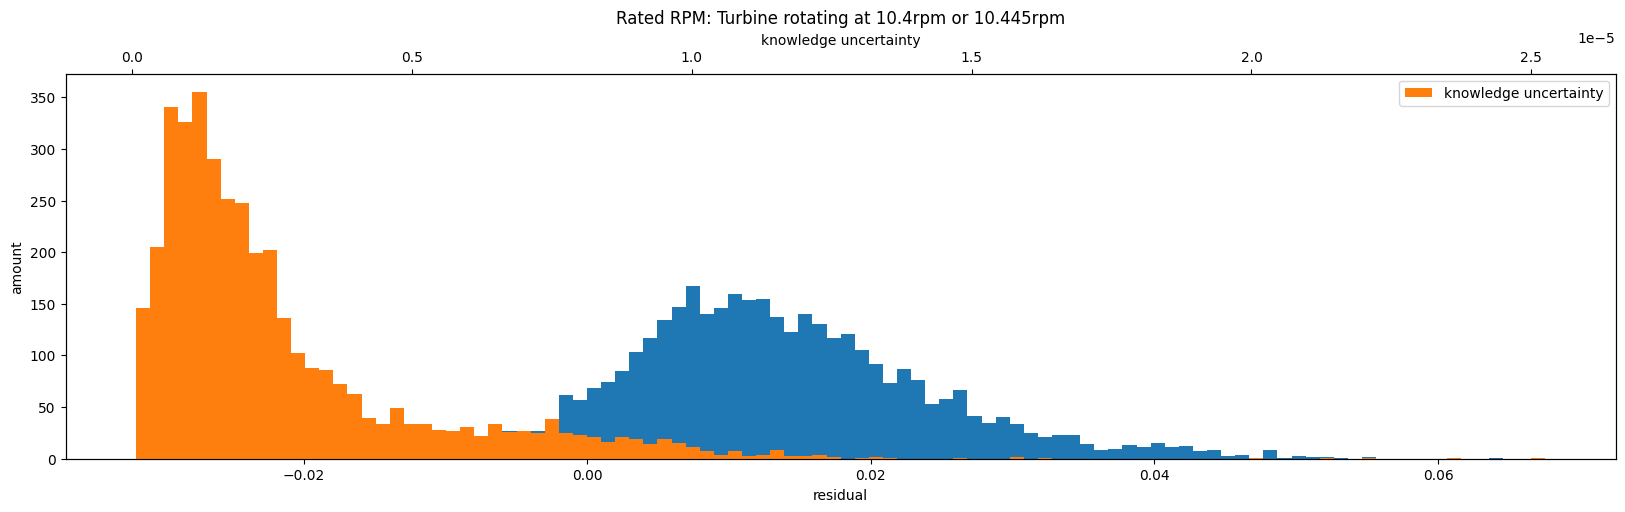

10


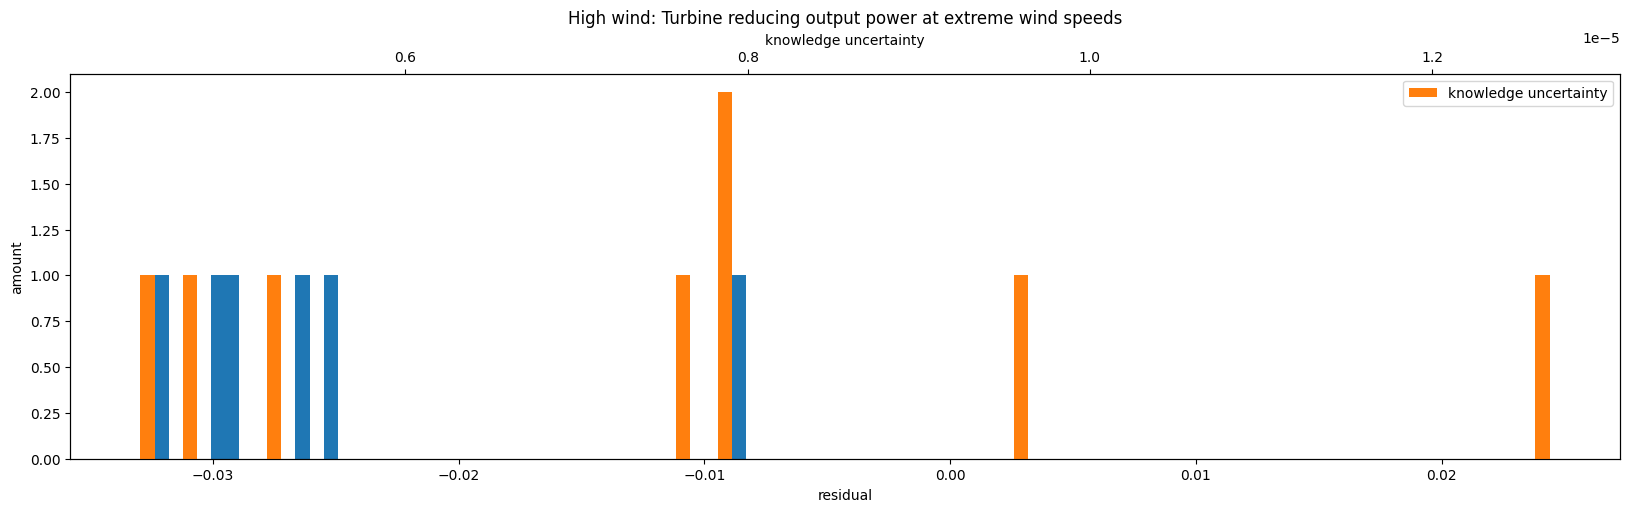

8


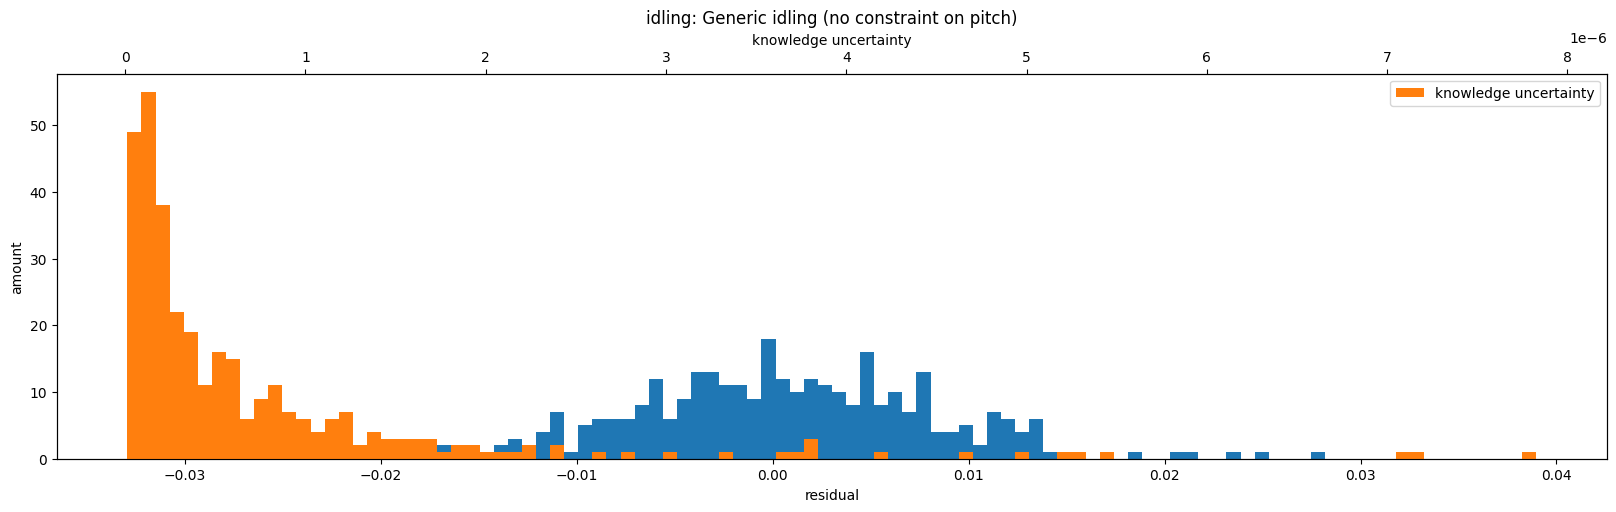

In [87]:
for case in case_IDS.loc[predictions_df_training.index]['caseID'].unique():
    fig, ax = plt.subplots(figsize=(20,5))
    print(case)
    plt_data = predictions_df_training[case_IDS.loc[predictions_df_training.index]['caseID']==case]
    ax.hist(plt_data['residual'], bins=100, color='tab:blue', label='residual')
    ax.set_xlabel('residual')
    #plt.xlim(0,0.2*1e-5)
    ax.set_ylabel('amount')
    ax2 = ax.twiny()
    ax2.hist(plt_data['knowledge_uncertainty'], bins=100, color='tab:orange', label='knowledge uncertainty')
    ax2.set_xlabel('knowledge uncertainty')
    plt.title(cases[case])
    plt.legend()
    plt.show()
    plt.close()

9


C:\Users\Max\AppData\Local\Temp\ipykernel_34812\399276905.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(plt_data['knowledge_uncertainty'], np.abs(plt_data['residual']), label='training data', s=2, alpha = 0.2, cmap='tab10')


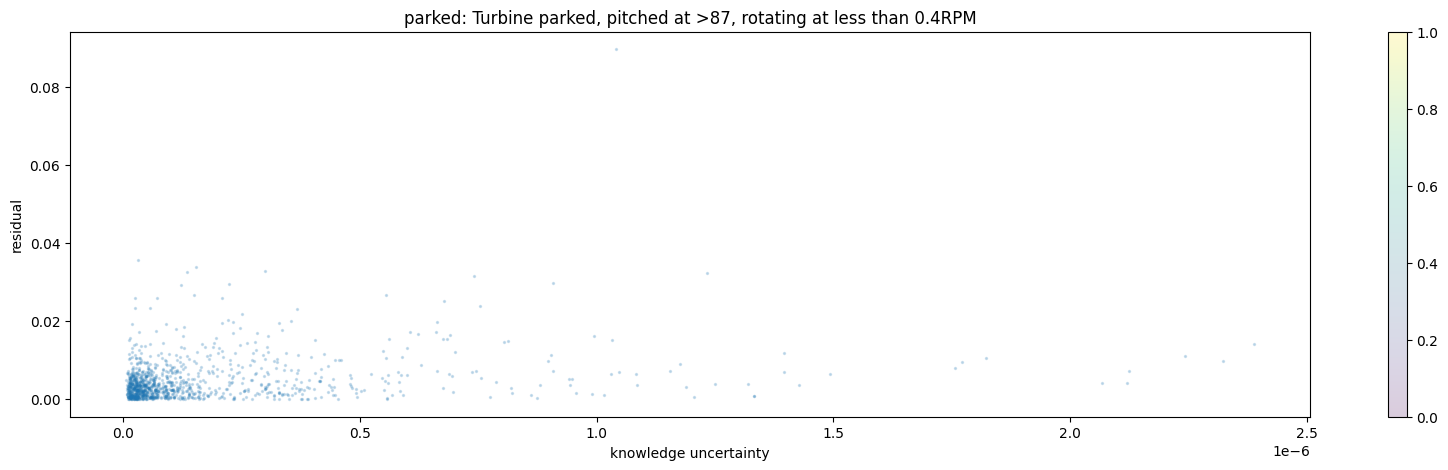

3


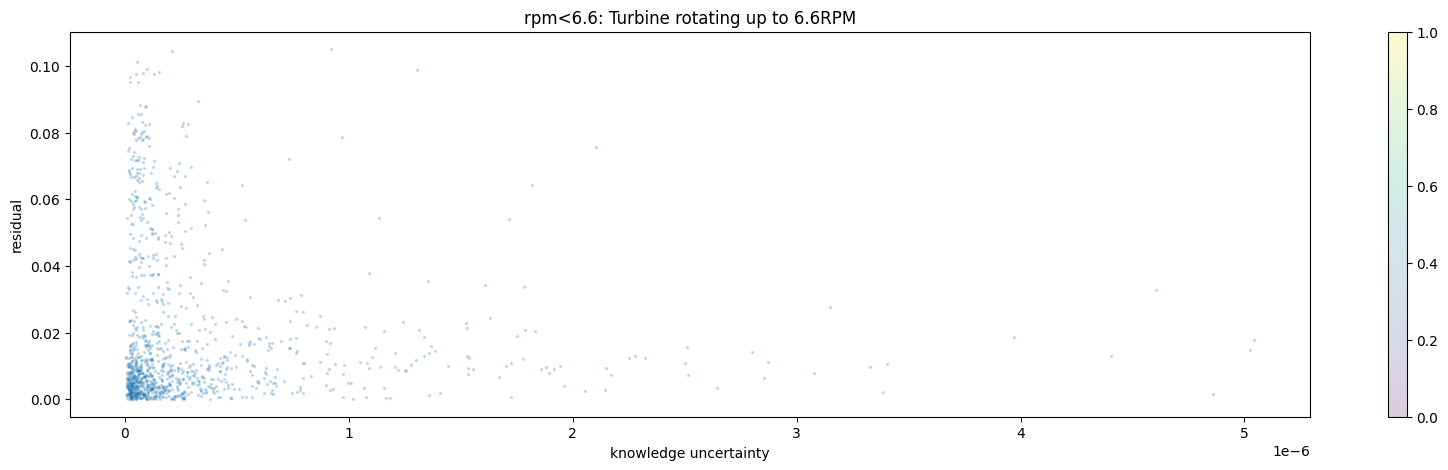

2


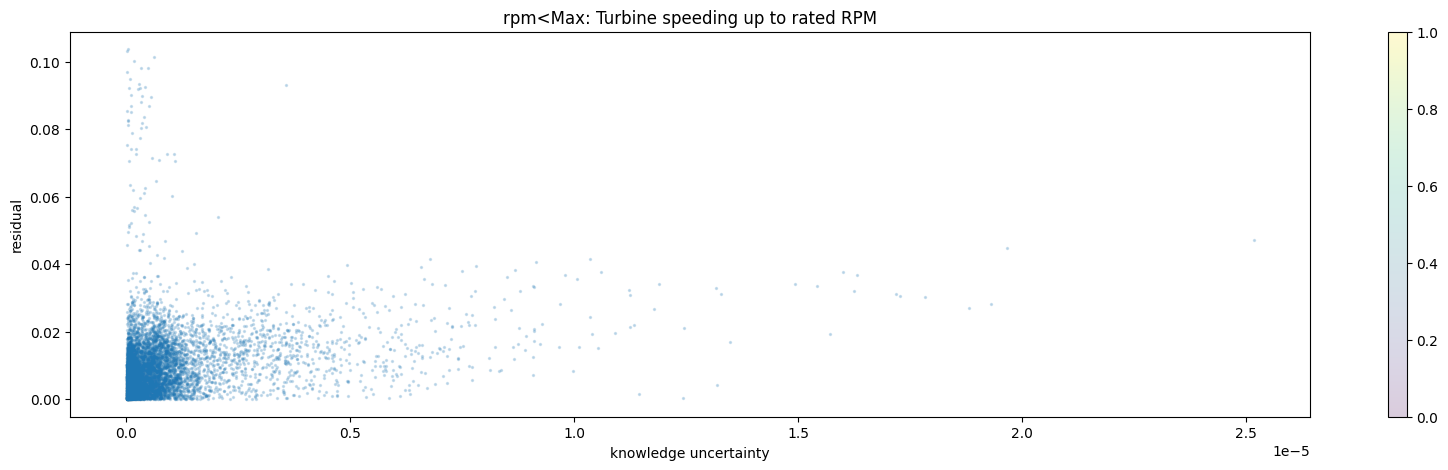

0


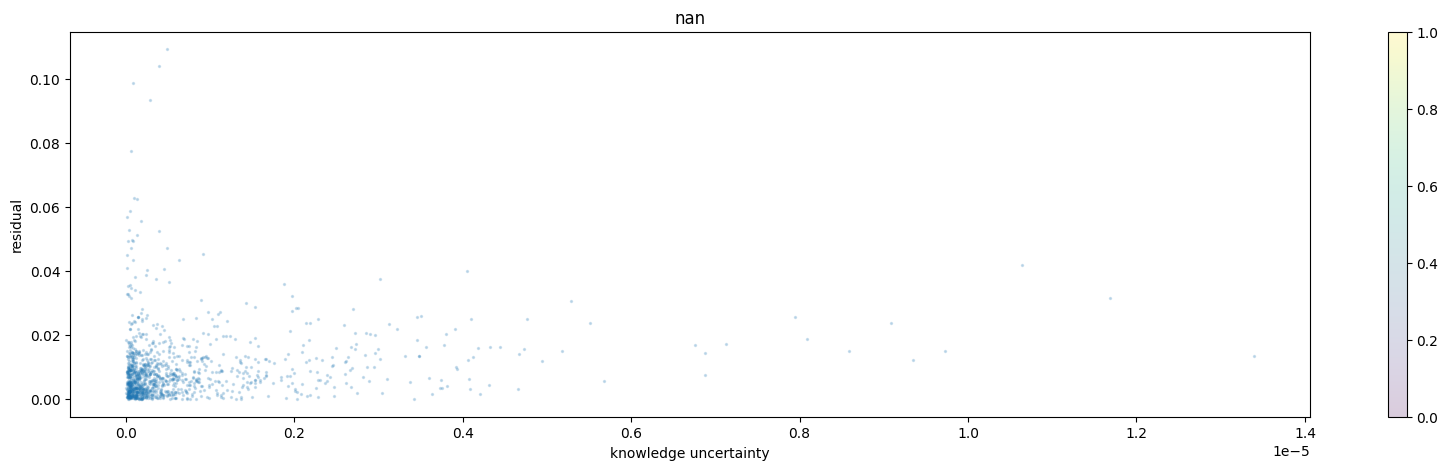

6


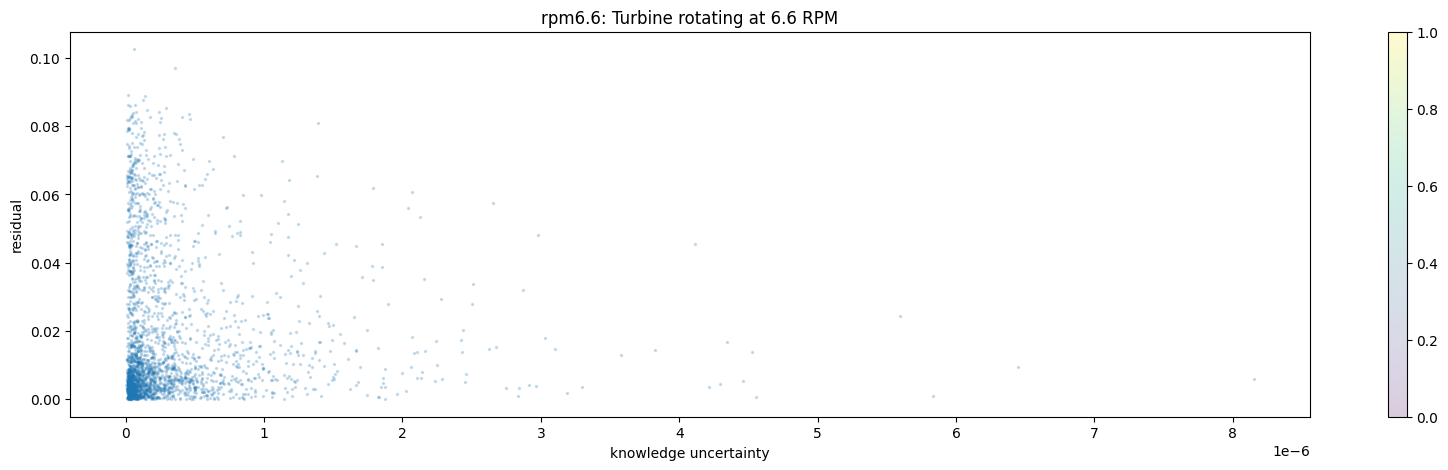

7


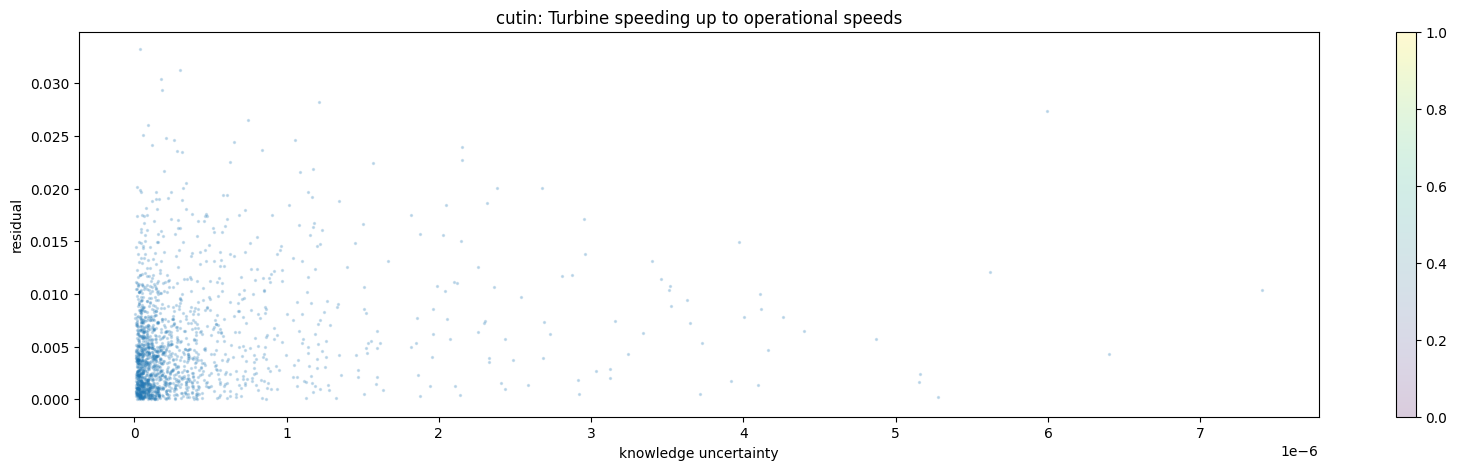

5


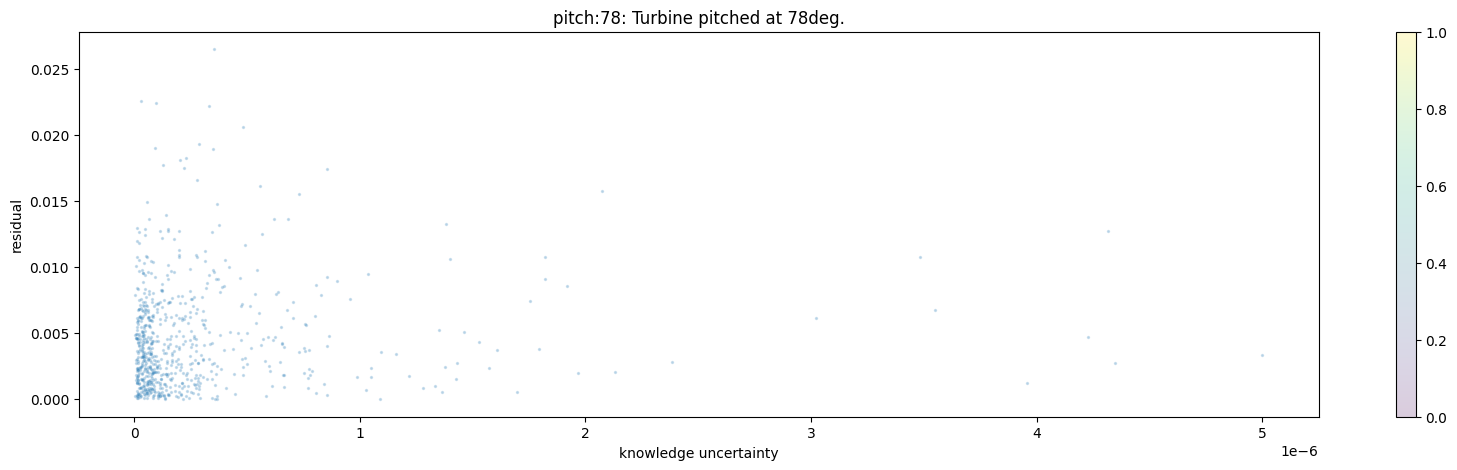

4


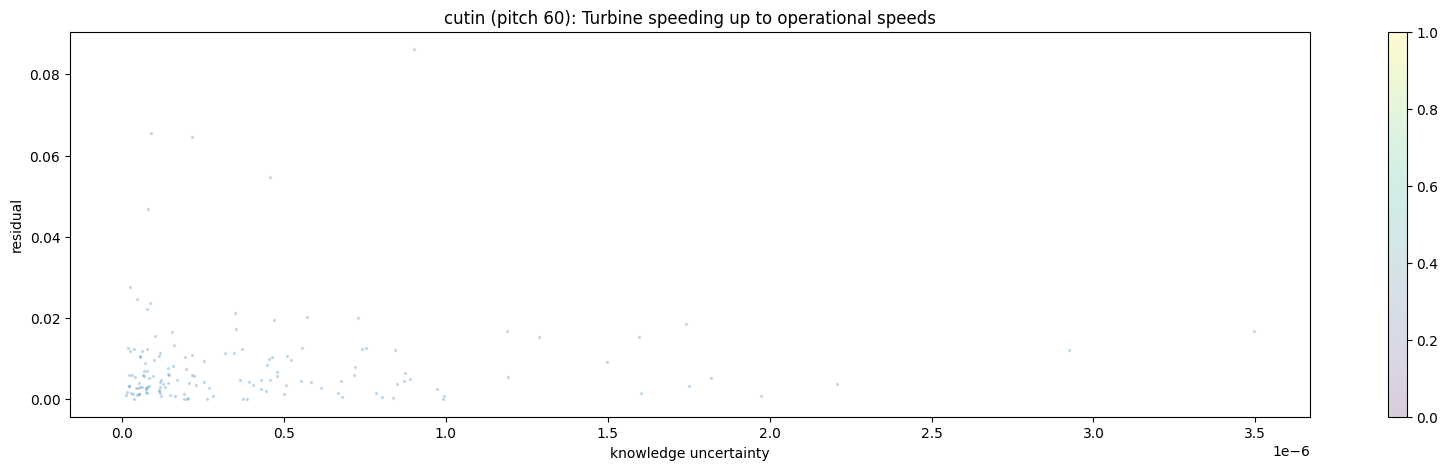

1


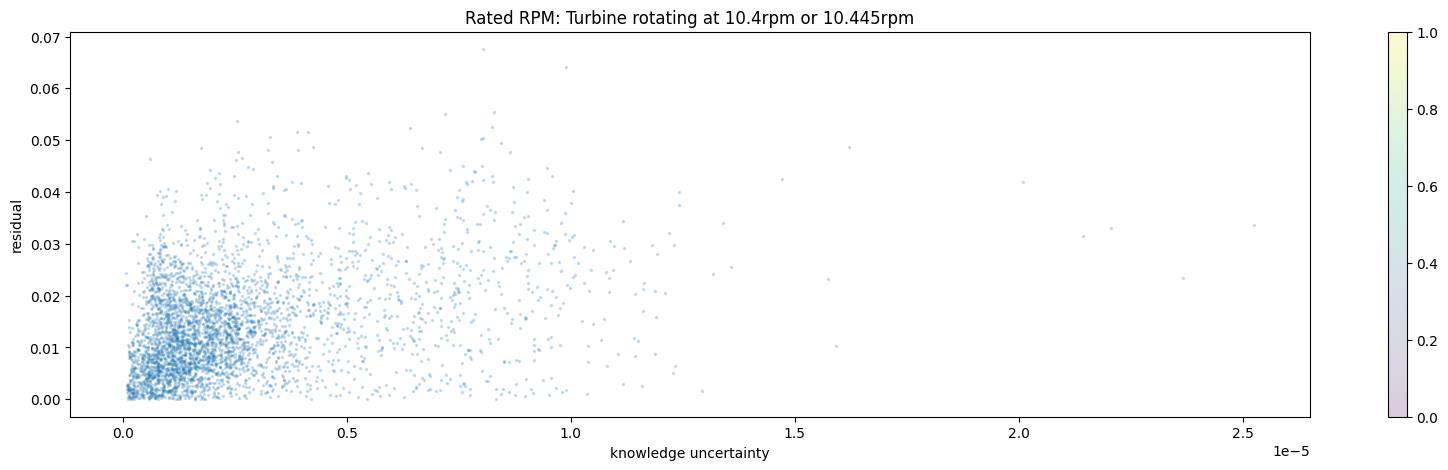

10


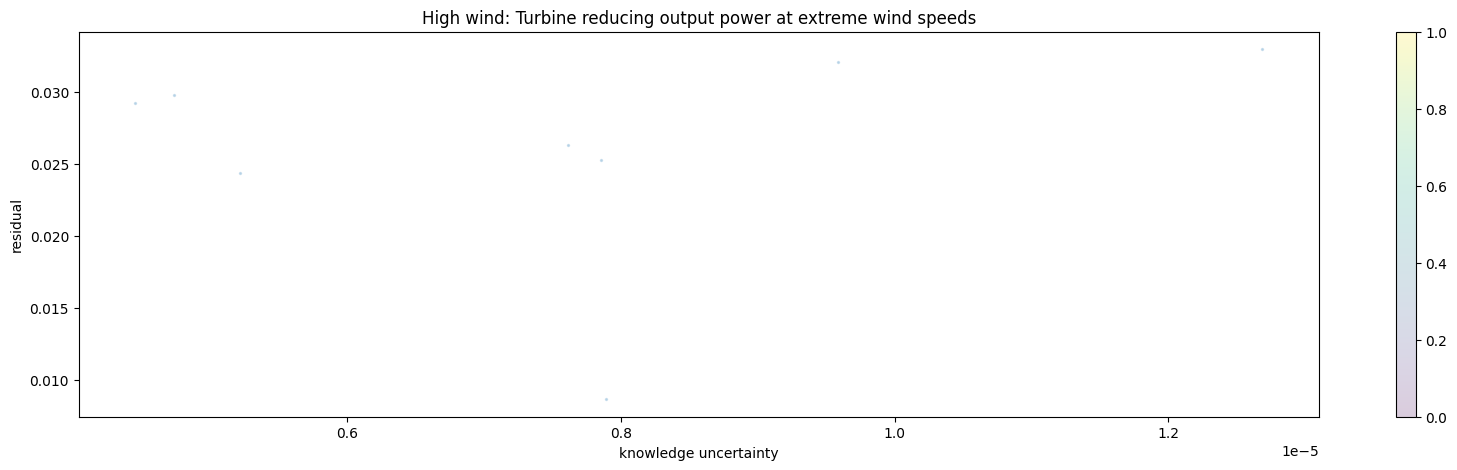

8


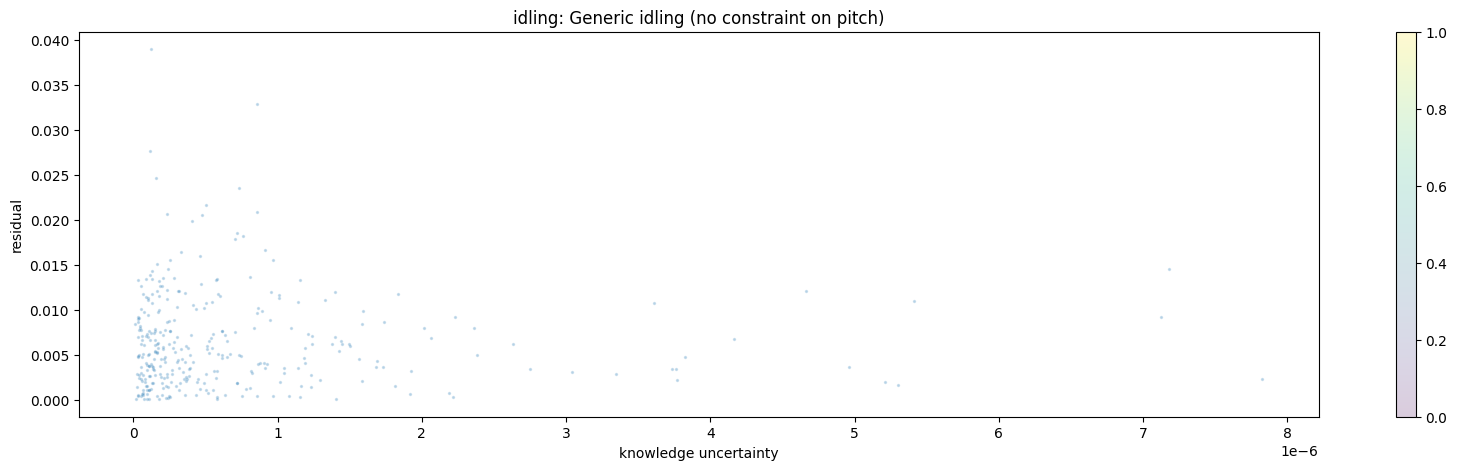

In [59]:
for case in case_IDS.loc[predictions_df_training.index]['caseID'].unique():
    print(case)
    plt_data = predictions_df_training[case_IDS.loc[predictions_df_training.index]['caseID']==case]
    plt.figure(figsize=(20,5))
    plt.scatter(plt_data['knowledge_uncertainty'], np.abs(plt_data['residual']), label='training data', s=2, alpha = 0.2, cmap='tab10')
    cbar = plt.colorbar()
    cbar.set_alpha(1)
    plt.xlabel('knowledge uncertainty')
    #plt.xlim(0,0.2*1e-5)
    plt.ylabel('residual')
    plt.title(cases[case])
    plt.show()
    plt.close()